In [1]:
import pandas as pd
from collections import defaultdict

# Reading the dataset
review_df = pd.read_json('../dataset/reviews.jl', lines=True, encoding='utf-8')
game_df = pd.read_json('../dataset/games.jl', lines=True, encoding='utf-8')

# Merging review and game dataset for processing
df = review_df.merge(game_df, how="inner", right_on='id', left_on='product_id')
df = df[['user_id', 'app_name', 'product_id', 'recommended']]
df.drop_duplicates(subset=['user_id', 'app_name', 'product_id'], inplace=True)
df = df.dropna()

# Finding users who have given a minimum of 100 reviews
game_count = df.groupby('user_id')['product_id'].count().sort_values(ascending=True)
game_count = game_count[game_count > 100]
common_games = df[df['user_id'].isin(game_count.index)]
common_games = common_games.sample(common_games.shape[0], random_state=50)

# Getting 80 percentage of the data as training data and 20% as testing data
common_games_train = common_games.head(int(len(common_games)*(80/100)))
common_games_test = common_games[~common_games.index.isin(common_games_train.index)]
common_games_test = common_games_test[['product_id', 'user_id', 'recommended']]

# Creating a csv file to find hybrid ROC-AUC
common_games[['user_id', 'product_id', 'recommended']].to_csv('cg_collaborative.csv')

# Creating the user game pivot table dataframe
user_game_df = pd.pivot_table(common_games_train, index=['user_id'], columns=['product_id'], values='recommended')

# Function to find recommendations for a given user_id
def recommendation(user_id):

    # Getting games played by the particular user_id
    random_user_df = user_game_df[user_game_df.index == user_id]
    games_played = random_user_df.columns[random_user_df.notna().any()].tolist()

    # Restricting columns to only the games played by the particular user
    games_played_df = user_game_df[games_played]
    user_game_count = games_played_df.T.notnull().sum()
    user_game_count = user_game_count.reset_index()
    user_game_count.columns = ["user_id", "game_count"]
    users_same_games = user_game_count[user_game_count["game_count"] > 0]["user_id"]
    final_df = pd.concat([games_played_df[games_played_df.index.isin(users_same_games.values)],
                          random_user_df[games_played]])

    # Finding correlation between users who have played the same games played the particular user
    correlation_df = final_df.T.corr(
        method='kendall').unstack().sort_values().drop_duplicates()
    correlation_df = pd.DataFrame(correlation_df, columns=["corr"])
    correlation_df.index.names = ['user_id_1', 'user_id_2']
    correlation_df = correlation_df.reset_index()

    # Finding positively correlated users
    positive_corr_users = correlation_df[(correlation_df["user_id_1"] == user_id) & (
        correlation_df["corr"] >= 0)][["user_id_2", "corr"]].reset_index(drop=True)
    positive_corr_users = positive_corr_users.sort_values(by='corr', ascending=False)
    positive_corr_users.rename(columns={"user_id_2": "user_id"}, inplace=True)
    positive_corr_users_ratings = positive_corr_users.merge(
        review_df[["user_id", "product_id", "recommended"]], how='inner')
    positive_corr_users_ratings = positive_corr_users_ratings[positive_corr_users_ratings["user_id"] != user_id]
    positive_corr_users_ratings['weighted_rating'] = positive_corr_users_ratings['corr'] * \
        positive_corr_users_ratings['recommended']

    recommendation_df = positive_corr_users_ratings.groupby(
        'product_id').agg({"weighted_rating": "mean"})
    recommendation_df = recommendation_df.reset_index()
    recommendation_df.sort_values(by='weighted_rating', ascending=False).head()
    games_to_be_recommend = recommendation_df[recommendation_df["weighted_rating"] > 0].sort_values(
        "weighted_rating", ascending=False)
    final_game_suggestions = games_to_be_recommend.merge(
        game_df[["id", "title"]], left_on='product_id', right_on='id')[['product_id', 'weighted_rating']]
    
    # Making sure already played games are not recommended
    final_game_suggestions =final_game_suggestions[~final_game_suggestions.product_id.isin(games_played)]
    final_game_suggestions = final_game_suggestions.values.tolist()
    return final_game_suggestions


# Testing
def ROC(list_of_users, threshold):

    user_predictions = defaultdict(list)

    for uid in list_of_users:
        pred = recommendation(uid)
        user_predictions[uid].append(pred)

    om_specificity = dict()
    sensitivity = dict()
    for uid, games in user_predictions.items():

        # Recommended liked games
        reco_l_games = [product_id for product_id,
                        weighted_avg in games[0] if weighted_avg > threshold]
        reco_l_games = set(reco_l_games)

        # Recommended unliked games
        reco_ul_games = [product_id for product_id,
                         weighted_avg in games[0] if weighted_avg < threshold]
        reco_ul_games = set(reco_ul_games)

        common_games_t = common_games_test[common_games_test.user_id == uid]
        ul_games = common_games_t[common_games_t.recommended ==
                                  0]['product_id'].values.tolist()
        ul_games = set(ul_games)
        l_games = common_games_t[common_games_t.recommended ==
                                 1]['product_id'].values.tolist()
        l_games = set(l_games)

        true_positives = l_games & reco_l_games
        false_negatives = ul_games & reco_ul_games
        false_positives = ul_games & reco_l_games
        true_negatives = l_games & reco_ul_games

        om_specificity[uid] = len(false_positives) / (len(false_positives) + len(
            true_negatives)) if (len(false_positives) + len(true_negatives)) != 0 else 0
        sensitivity[uid] = len(true_positives) / (len(true_positives) + len(
            false_negatives)) if (len(true_positives) + len(false_negatives)) != 0 else 0

    return sensitivity, om_specificity



In [2]:
#Creating a list of threshold values for ROC_AUC calculation
number_list = []
s = 0
e = 1
number_gap = 0.1
for i in range(int((e-s)/number_gap)+1):
    number_list.append(s + i*number_gap)

#Cumulating list of users common between training and testing data    
list_of_users = list(set(common_games_train.user_id) & set(common_games_test.user_id))
list_of_users=[int(i) for i in list_of_users]

In [6]:
#Sensitivity and 1-Specificity calculation for ROC_AUC calcuation 
x =list()
y =list()
for i in number_list:
    sensitivity, om_specificity = ROC(list_of_users,i)
    y.append(sum(sens for sens in sensitivity.values()) / len(sensitivity))
    x.append(sum(oms for oms in om_specificity.values()) / len(om_specificity))

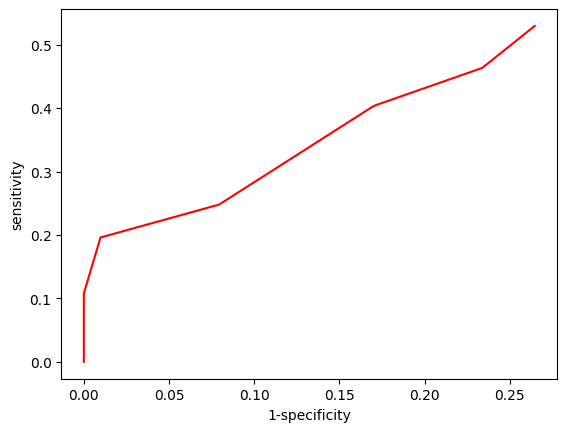

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
fig, ax = plt.subplots()

ax.plot(x, y, color='red')
ax.set_xlabel('1-specificity')
ax.set_ylabel('sensitivity')

plt.savefig('ROC_Collaborative.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
roc_auc = auc(x, y)

# Print the AUC value
print(roc_auc)

In [10]:
#Saving data for final plot
collaborative_df = pd.DataFrame({'x': x, 'y': y})
collaborative_df.to_csv("ROC_collaborative_data.csv")